# Merge all Config Manager features into one dataframe
### Step 1: Load data into pandas dataframes 
Our team has spent some time in creating features from the tables in the Microsoft Configuration Manager database. Our features are stored in separate sources for each Config Manager table that we created features from. We have two types of data sources of features that we need to join together for our model:
1. `.parquet` files in blob storage 
2. SQL views from our cloud database 

We have tracked the data source file names and SQL views using a spreadsheet, and will use this list to pull the filenames and data from our cloud database and blob storage.


In [1]:
# Import modules 
from azure.storage.blob import BlobServiceClient
import missingno as msno
import pandas as pd 
import numpy
import pyodbc
import os
import json
import time

# Set the notebook to display all columns of a dataframe
pd.set_option('display.max_columns', None)

# Function Definitions --------------

def download_blob(cred, LOCALFILENAME,
                  CONTAINERNAME, BLOBNAME):

    # Start tracking download time
    t1=time.time()

    # Instantiate a blob service instance
    blob_service_client_instance = BlobServiceClient(account_url=cred['in_the_sun'], credential=cred['fun'])
    blob_client_instance = blob_service_client_instance.get_blob_client(CONTAINERNAME, BLOBNAME, snapshot=None)

    # Create the file locally
    with open(LOCALFILENAME, "wb") as my_blob:
        blob_data = blob_client_instance.download_blob()
        blob_data.readinto(my_blob)
    
    # Notify user of download time 
    t2=time.time()
    print(("It takes %s seconds to download "+BLOBNAME) % (t2 - t1))

def connect_to_database(cred):
    ''' 
    Uses pyodbc to connect to a SQL Server database
    and returns the connection object
    '''
    # Define database driver, server, database
    driver = 'SQL SERVER'

    # Define the connection string
    conn_str = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={cred['server']};DATABASE={cred['db']};UID={cred['uid']};PWD={cred['pwd']}"

    # Connect to database using windows authentication 
    conn = pyodbc.connect(conn_str)

    return conn 

def get_sql_data(persist_conn_obj, sql_query):
    ''' 
    Gets rows from a table in the SQL database connection
    '''
    # Execute a query for table table
    df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)
    
    return df_pers_all

def get_creds(in_file):
    with open(in_file) as f:
        cred = json.load(f)
    return cred

# Get creds 
creds_file = 'assets/fun.json'
creds = get_creds(creds_file)


In [2]:
def get_feature_metadata():

    # Read the EDA feature metadata 
    df = pd.read_excel('assets/EDA _ Feature Engineering Tasks.xlsx', sheet_name='Features to Engineer')

    # Select only completed features 
    df['Completed? (Y/N)'] = df['Completed? (Y/N)'].apply(lambda x: x.strip())
    df = df[df['Completed? (Y/N)'] == 'Y']

    # Get only one row per view/filename
    out_df = df[['Completed dataset location', 'View/Filename', 'Keys']]
    out_df = out_df.drop_duplicates()

    return out_df

def download_all_data(metadata_df, save_directory, creds):

    # Instantiate a dictionary to accumulate dataframes
    feature_dfs = {}

    # Start a SQL connection 
    conn = connect_to_database(creds)

    # Iterate through each view/file
    for row in metadata_df.iterrows():
        
        row = row[1]

        # Download and read Blob file
        if row['Completed dataset location'] == 'Blob Storage':
            
            # Download from blob storage
            blob_name = row['View/Filename']
            file_save_name = os.path.join(save_directory, blob_name)
            download_blob(creds, file_save_name, 'configmanagertest1', blob_name)

            # Read the blob into a dataframe and add to output dict
            current_df = pd.read_parquet(file_save_name)
            feature_dfs[blob_name] = current_df

        # Download and read SQL 
        if row['Completed dataset location'] == 'SQL View':
            
            # Call SQL to get data
            view_name = row['View/Filename']
            sql_query = f'SELECT * FROM {view_name}'
            current_df = get_sql_data(conn, sql_query)

            # Add data to output dict
            feature_dfs[view_name] = current_df
            print(f'retrieved {view_name} from SQL')
    
    return feature_dfs

# Download data 
save_location = 'assets/features'
df = get_feature_metadata()
feature_datasets = download_all_data(df, save_location, creds)


It takes 0.5373809337615967 seconds to download add_remove_programs_features.parquet
It takes 0.37574076652526855 seconds to download office_addin_features.parquet


/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_5033/2976849977.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)


retrieved Machine_Enclosure_Types from SQL
It takes 0.19174504280090332 seconds to download update_summary_features.parquet


/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_5033/2976849977.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)


retrieved Battery_Health_View from SQL
It takes 0.23186898231506348 seconds to download browser_usage_features.parquet
It takes 0.12508487701416016 seconds to download computer_system_features.parquet


/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_5033/2976849977.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)


retrieved Logical_Disk_Data_View from SQL
retrieved Machine_Office_Is32Bit from SQL
retrieved Office_Readiness_View from SQL
retrieved Processor_DATA_View from SQL
It takes 0.4180259704589844 seconds to download user_count_feature.parquet
It takes 0.6499509811401367 seconds to download boot_events_parsed_features.pq
It takes 0.29076218605041504 seconds to download num_events.pq
It takes 0.3326270580291748 seconds to download operating_system_features.pq
It takes 0.2019510269165039 seconds to download pc_bios_data.pq
It takes 0.2097618579864502 seconds to download pc_memory_data.pq
It takes 0.7128310203552246 seconds to download system_disc_features.pq
It takes 1.6175661087036133 seconds to download workstationstatus_features.pq


In [3]:
# Function to yield a generator of dataframes 
def view_data(in_dict):

    for key in in_dict.keys():

        dat = in_dict[key]
        print(key, len(dat))
        yield dat

generator = view_data(feature_datasets)

In [15]:
# View each dataframe 
current = next(generator)
current.head()

user_count_feature.parquet 1044257


,MachineID,RWB_EFFECTIVE_DATE,num_users
0,16783564,2023-01-19,2
1,16783564,2023-01-20,2
2,16783564,2023-01-21,2
3,16783564,2023-01-22,2
4,16783564,2023-01-23,1


### Step 2: Join all features into one dataframe 


In [16]:
def join_all_features(features_dict, metadata_df):

    # Get the system_disc table 
    system_name = 'system_disc_features.pq'
    system_df = features_dict[system_name]

    # Drop rows in system_disc that have may 20th 2023
    system_df = system_df[system_df['RWB_EFFECTIVE_DATE'] != '2023-05-20']

    # Update the type of RWB_EFFECTIVE_DATE to str
    system_df['RWB_EFFECTIVE_DATE'] = system_df['RWB_EFFECTIVE_DATE'].astype(str)

    # Iterate through each file 
    for row in metadata_df.iterrows():
        row = row[1]

        # Get the table and key on the right to join to system disc
        right_df_name = row['View/Filename']
        right_df = features_dict[right_df_name]
        right_keys = row['Keys'].split(', ')

        # skip if df is system disc
        if right_df_name == system_name:
            continue
        
        # Get the system disc key and change type of right key date
        if 'RWB_EFFECTIVE_DATE' in right_keys:
            left_keys = ['ItemKey', 'RWB_EFFECTIVE_DATE']
            right_df['RWB_EFFECTIVE_DATE'] = right_df['RWB_EFFECTIVE_DATE'].astype(str)
            right_df = right_df[right_df['RWB_EFFECTIVE_DATE'] != '2023-05-20']
        elif 'created_date' in right_keys:
            left_keys = ['ItemKey', 'RWB_EFFECTIVE_DATE']
            right_df['created_date'] = right_df['created_date'].astype(str)
        else:
            left_keys = ['ItemKey']

        # Perform a left join for the features 
        system_df = pd.merge(system_df, right_df, 
                             how='left',
                             left_on=left_keys,
                             right_on=right_keys,
                             copy=False)
        
        if 'MachineID' in system_df.columns:
            system_df = system_df.drop('MachineID', axis=1)
        elif 'ClientItemKey' in system_df.columns:
            system_df = system_df.drop('ClientItemKey', axis=1)
        elif 'created_date' in system_df.columns:
            system_df = system_df.drop('created_date', axis=1)
        
    return system_df

final_df = join_all_features(feature_datasets, df)

/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_5033/3229483997.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_df['RWB_EFFECTIVE_DATE'] = system_df['RWB_EFFECTIVE_DATE'].astype(str)


<Axes: >

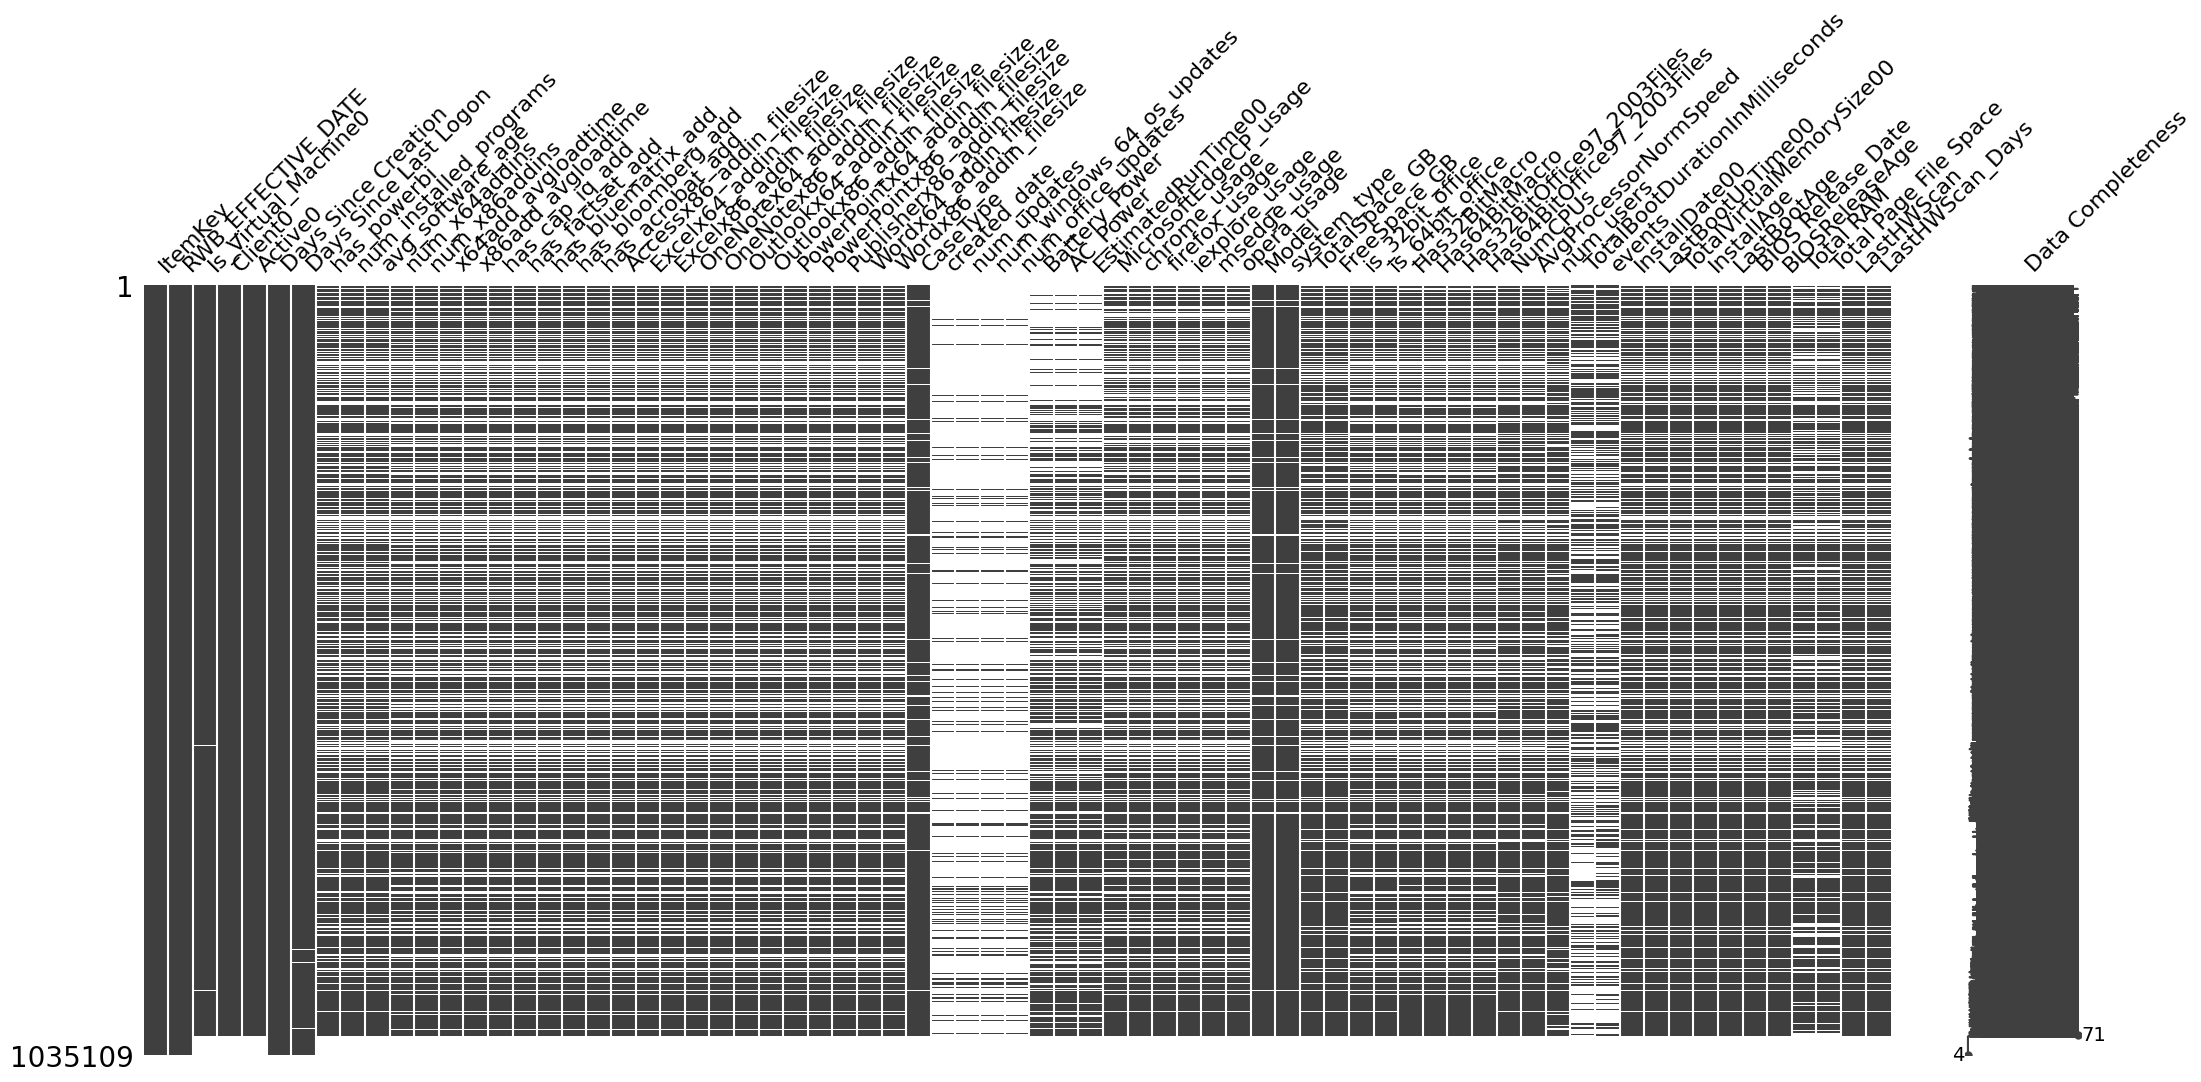

In [17]:
# View MissingNo matrix
msno.matrix(final_df, labels=True)

## Feature cleaning notes 

### High null counts 
I am planning on dropping the following features from our joined dataset due to very high null value counts:

`['num_updates', 'num_windows_64_os_updates','num_office_updates']`

While the update features are interesting, I am willing to sacrifice the trade off between having more data in our training set versus including the update features in our model. We can always go back and run the model while retaining the update features in the future.

### Removing date features 
We need to remove the following date features so our model only contains numeric values:

`['created_date', 'InstallDate00', 'LastBootUpTime00', 'BIOS Release Date', 'LastHWScan']`

### Drop rows that have any `NaN` value
Given time constraints and dataset size, we will be dropping any rows that have a `NaN` missing value. Future work may attempt to impute the missing values. We will save the records that were dropped to do analysis and check for patterns in machine characteristics to make sure we are not losing a large subset of machine categories.

### Step 3: Clean the joined dataset

In [27]:
def clean_joined_data(in_df):

    # Drop columns with high null count and remove date features
    high_nulls = ['num_updates', 'num_windows_64_os_updates','num_office_updates']
    date_features = ['created_date', 'InstallDate00', 'LastBootUpTime00',
                      'BIOS Release Date', 'LastHWScan']
    cols_to_drop = high_nulls + date_features
    out_df = in_df[[col for col in in_df.columns if col not in cols_to_drop]]

    # If event data is NaN, let's assume the machine did not 
    # have an event for that day.
    out_df['events'] = out_df['events'].apply(lambda x: x if pd.notnull(x) else 0)

    # Drop rows with any NaN value
    out_df = out_df.dropna(axis=0, how='any')

    # Drop columns that have only one value
    for col in out_df.columns:
        if len(out_df[col].unique()) <= 1:
            out_df = out_df.drop(col, axis=1)

    return out_df

cleaned_df = clean_joined_data(final_df)
cleaned_df.head()

/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_5033/2800319590.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df['events'] = out_df['events'].apply(lambda x: x if pd.notnull(x) else 0)


,ItemKey,RWB_EFFECTIVE_DATE,Is_Virtual_Machine0,Days Since Creation,Days Since Last Logon,has_powerbi,num_installed_programs,avg_software_age,num_x64addins,num_x86addins,x64add_avgloadtime,x86add_avgloadtime,has_cap_iq_add,has_factset_add,has_bluematrix_add,has_bloomberg_add,has_acrobat_add,Accessx86_addin_filesize,Excelx64_addin_filesize,Excelx86_addin_filesize,OneNotex64_addin_filesize,OneNotex86_addin_filesize,Outlookx64_addin_filesize,Outlookx86_addin_filesize,PowerPointx64_addin_filesize,PowerPointx86_addin_filesize,Publisherx86_addin_filesize,Wordx64_addin_filesize,Wordx86_addin_filesize,CaseType,Battery_Power,AC_Power,EstimatedRunTime00,chrome_usage,firefox_usage,iexplore_usage,msedge_usage,Model,TotalSpace_GB,FreeSpace_GB,is_32bit_office,is_64bit_office,Has32BitMacro,Has64BitMacro,Has32BitOffice97_2003Files,Has64BitOffice97_2003Files,AvgProcessorNormSpeed,num_users,TotalBootDurationInMilliseconds,events,TotalVirtualMemorySize00,InstallAge,LastBootAge,BIOSReleaseAge,Total RAM,Total Page File Space,LastHWScan_Days
5186,16789712,2023-02-03,0.0,1487,3.0,0.0,58.0,913.200000,8.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2902320.0,3579576.0,0.0,0.0,2298664.0,5148632.0,1124264.0,1583968.0,0.0,1124264.0,1627960.0,Laptop,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,Latitude 7290,237.0,87.0,1.0,0.0,0.0,0.0,0.0,0.0,1900.0,2.0,64959.0,18.0,33666.0,689.0,1.0,277.0,16648448.0,17825792.0,1.0
5189,16789712,2023-02-06,0.0,1490,6.0,0.0,58.0,913.044444,10.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2902320.0,3579576.0,0.0,0.0,2785928.0,5605208.0,1124264.0,1583968.0,0.0,1124264.0,1627960.0,Laptop,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,Latitude 7290,237.0,85.0,1.0,0.0,1.0,1.0,0.0,0.0,1900.0,2.0,64805.0,9.0,33666.0,689.0,1.0,277.0,16648448.0,17825792.0,1.0
5190,16789712,2023-02-07,0.0,1491,7.0,0.0,58.0,913.044444,10.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2902320.0,3579576.0,0.0,0.0,2785928.0,5605208.0,1124264.0,1583968.0,0.0,1124264.0,1627960.0,Laptop,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,Latitude 7290,237.0,85.0,1.0,0.0,1.0,1.0,0.0,0.0,1900.0,2.0,56865.0,2.0,33666.0,689.0,1.0,277.0,16648448.0,17825792.0,1.0
5191,16789712,2023-02-08,0.0,1492,8.0,0.0,58.0,913.044444,10.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2902320.0,3579576.0,0.0,0.0,2785928.0,5605208.0,1124264.0,1583968.0,0.0,1124264.0,1627960.0,Laptop,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,Latitude 7290,237.0,85.0,1.0,0.0,1.0,1.0,0.0,0.0,1900.0,2.0,57332.0,2.0,33666.0,689.0,1.0,277.0,16648448.0,17825792.0,1.0
5193,16789712,2023-02-10,0.0,1494,10.0,0.0,59.0,894.869565,10.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2902320.0,3579576.0,0.0,0.0,2785928.0,5605208.0,1124264.0,1583968.0,0.0,1124264.0,1627960.0,Laptop,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,Latitude 7290,237.0,86.0,1.0,0.0,1.0,1.0,0.0,0.0,1900.0,2.0,57324.0,2.0,33666.0,689.0,0.0,277.0,16648448.0,17825792.0,0.0


### Observations 
* Machines with `system_type` that are `x86_64` and `arm64` are dropped from the data when we drop rows with any `NaN` values.
* Only 10% of the final joined dataset remains after dropping rows with any `NaN` values.

In [28]:
print('final_df length:', len(final_df))
print('cleaned_df length:', len(cleaned_df))
#181352

final_df length: 1035109
cleaned_df length: 181352


In [29]:
# Compare models that were dropped
print(cleaned_df['Model'].unique())
print(final_df['Model'].unique())

['Latitude 7290' 'Latitude 5590' 'Latitude E7270' 'Latitude E7470'
 'Latitude 7300' 'Latitude 5500' 'Surface Pro 7' 'Latitude 5510'
 'Latitude 9510' 'Latitude 9520' 'Latitude 7320 Detachable'
 'Surface Pro 7+' 'Precision 3561' 'Latitude 7320' 'Precision 3571'
 'Latitude 7330' 'Latitude 7530' 'Precision 5760' 'Latitude 7340']
['VMware Virtual Platform' 'Latitude E7270' nan 'OptiPlex 5050'
 'Latitude 5590' 'Precision Tower 3430' 'Latitude 7290' 'OptiPlex 5060'
 'Surface Pro 6' 'Latitude E7470' 'Latitude 7300' 'OptiPlex 5070'
 'Latitude 5500' 'Precision Tower 3431' 'Surface Pro 7' 'Latitude 5510'
 'Latitude 9510' 'Latitude 9520' 'MacBook Pro (16-inch, 2019)'
 'Latitude 7320' 'MacBook Pro (15-inch, 2018)' 'Latitude 7320 Detachable'
 'Surface Pro 7+' 'Precision 3561' 'MacBook Pro (16-inch, 2021)'
 'MacBook Pro (14-inch, 2021)' 'Precision 5760' 'Precision 3450'
 'iMac Intel (Retina 5k, 27-inch, Mid 2017)' 'OptiPlex 5080'
 'Virtual Machine' 'Precision 3571' 'Latitude 7330' 'VMware7,1'
 'Latit

In [30]:
# optional, view data in Dtale
# import dtale
# dtale.show(final_df).open_browser() 

In [31]:
# Write fully joined dataset to parquet 
final_df.to_parquet('assets/CM_all_joined_20230804.parquet', index=False)

# Write non-null fully joined dataset result to parquet 
cleaned_df.to_parquet('assets/CM_all_notnull_20230804.parquet', index=False)

### Step 4: Encode Categorical Features

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

def encode_attr(in_df, attrs):
    
    # Get the category labels and  categories
    categories = [(attr, list(in_df[attr].unique())) for attr in attrs]
    ohe_columns = [x[0] for x in categories]
    ohe_categories = [x[1] for x in categories]

    # Instantiate the one hot encoder and fit it 
    enc = OneHotEncoder(sparse_output=False, categories=ohe_categories)
    transformer = make_column_transformer((enc, ohe_columns), remainder='passthrough')
    output = transformer.fit_transform(in_df)

    # Put results in dataframe and clean up columns
    out_df = pd.DataFrame(output, columns=transformer.get_feature_names_out())
    remainder_cols =  [col[11:] for col in out_df.columns if 'remainder' in col]
    encoded_cols = [col[15:] for col in out_df.columns if 'onehotencoder' in col]
    out_df.columns = encoded_cols + remainder_cols
    out_df = out_df[remainder_cols + encoded_cols]

    return out_df

encoded_clean_df = encode_attr(cleaned_df, ['Model', 'CaseType'])

In [33]:
encoded_clean_df.head()

,ItemKey,RWB_EFFECTIVE_DATE,Is_Virtual_Machine0,Days Since Creation,Days Since Last Logon,has_powerbi,num_installed_programs,avg_software_age,num_x64addins,num_x86addins,x64add_avgloadtime,x86add_avgloadtime,has_cap_iq_add,has_factset_add,has_bluematrix_add,has_bloomberg_add,has_acrobat_add,Accessx86_addin_filesize,Excelx64_addin_filesize,Excelx86_addin_filesize,OneNotex64_addin_filesize,OneNotex86_addin_filesize,Outlookx64_addin_filesize,Outlookx86_addin_filesize,PowerPointx64_addin_filesize,PowerPointx86_addin_filesize,Publisherx86_addin_filesize,Wordx64_addin_filesize,Wordx86_addin_filesize,Battery_Power,AC_Power,EstimatedRunTime00,chrome_usage,firefox_usage,iexplore_usage,msedge_usage,TotalSpace_GB,FreeSpace_GB,is_32bit_office,is_64bit_office,Has32BitMacro,Has64BitMacro,Has32BitOffice97_2003Files,Has64BitOffice97_2003Files,AvgProcessorNormSpeed,num_users,TotalBootDurationInMilliseconds,events,TotalVirtualMemorySize00,InstallAge,LastBootAge,BIOSReleaseAge,Total RAM,Total Page File Space,LastHWScan_Days,Model_Latitude 7290,Model_Latitude 5590,Model_Latitude E7270,Model_Latitude E7470,Model_Latitude 7300,Model_Latitude 5500,Model_Surface Pro 7,Model_Latitude 5510,Model_Latitude 9510,Model_Latitude 9520,Model_Latitude 7320 Detachable,Model_Surface Pro 7+,Model_Precision 3561,Model_Latitude 7320,Model_Precision 3571,Model_Latitude 7330,Model_Latitude 7530,Model_Precision 5760,Model_Latitude 7340,CaseType_Laptop,CaseType_Others
0,16789712,2023-02-03,0.0,1487,3.0,0.0,58.0,913.2,8.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2902320.0,3579576.0,0.0,0.0,2298664.0,5148632.0,1124264.0,1583968.0,0.0,1124264.0,1627960.0,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,237.0,87.0,1.0,0.0,0.0,0.0,0.0,0.0,1900.0,2.0,64959.0,18.0,33666.0,689.0,1.0,277.0,16648448.0,17825792.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,16789712,2023-02-06,0.0,1490,6.0,0.0,58.0,913.044444,10.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2902320.0,3579576.0,0.0,0.0,2785928.0,5605208.0,1124264.0,1583968.0,0.0,1124264.0,1627960.0,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,237.0,85.0,1.0,0.0,1.0,1.0,0.0,0.0,1900.0,2.0,64805.0,9.0,33666.0,689.0,1.0,277.0,16648448.0,17825792.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,16789712,2023-02-07,0.0,1491,7.0,0.0,58.0,913.044444,10.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2902320.0,3579576.0,0.0,0.0,2785928.0,5605208.0,1124264.0,1583968.0,0.0,1124264.0,1627960.0,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,237.0,85.0,1.0,0.0,1.0,1.0,0.0,0.0,1900.0,2.0,56865.0,2.0,33666.0,689.0,1.0,277.0,16648448.0,17825792.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,16789712,2023-02-08,0.0,1492,8.0,0.0,58.0,913.044444,10.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2902320.0,3579576.0,0.0,0.0,2785928.0,5605208.0,1124264.0,1583968.0,0.0,1124264.0,1627960.0,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,237.0,85.0,1.0,0.0,1.0,1.0,0.0,0.0,1900.0,2.0,57332.0,2.0,33666.0,689.0,1.0,277.0,16648448.0,17825792.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,16789712,2023-02-10,0.0,1494,10.0,0.0,59.0,894.869565,10.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2902320.0,3579576.0,0.0,0.0,2785928.0,5605208.0,1124264.0,1583968.0,0.0,1124264.0,1627960.0,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,237.0,86.0,1.0,0.0,1.0,1.0,0.0,0.0,1900.0,2.0,57324.0,2.0,33666.0,689.0,0.0,277.0,16648448.0,17825792.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Step 5: Split data into train, test, validation sets.

In [34]:
from sklearn.model_selection import train_test_split

def split_data_modelling(df):

    # Assuming your DataFrame is named 'df'
    # Splitting the data into train and temp sets (80% train + 20% temp)
    train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)

    # Splitting the temp set into test and validation sets (50% test + 50% validation)
    test_df, validation_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Printing the shapes of the resulting sets
    print("Train set shape:", train_df.shape)
    print("Test set shape:", test_df.shape)
    print("Validation set shape:", validation_df.shape)

    train_name = 'assets/training_set_v1.parquet'
    test_name = 'assets/test_set_v1.parquet'
    validate_name = 'assets/validation_set_v1.parquet'

    # Save datasets to parquet
    train_df.to_parquet(train_name)
    test_df.to_parquet(test_name)
    validation_df.to_parquet(validate_name)

split_data_modelling(encoded_clean_df)

Train set shape: (108811, 76)
Test set shape: (36270, 76)
Validation set shape: (36271, 76)
